# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules.

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results. Here are a few best practices:

* By default, keep this code unchanged.
* When producing final results for your report, (1) run this cell once to create a seed, (2) copy/paste this seed into the line of code that creates a simulator, and (3) replace the code cell that creates a seed with a markdown cell saying that you took this approach to choose a seed for testing.

In [409]:
seed = secrets.randbits(32)
print(seed)

2407782344


Create simulator with seed.

If your simulator runs much slower than real-time, then you can try adding the optional argument `display_pybullet=True` (instead of using meshcat views).

In [410]:
simulator = ae353_drone.Simulator(seed=seed)

argv[0]=


Add a camera view. This view will be displayed in its own browser window.

In [411]:
simulator.add_view(
    'top_view',  # name of view (must be unique)
    'top',       # type of view (start, top, right, left, or back)
)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [412]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=True,  # <-- allow long runtimes in controller code
    error_on_inactive=True, # <-- allow inactivity
)

## Example of how to add a drone and run a simulation

Clear all drones (there aren't any yet, if you are running this notebook from the start, but we call this function just in case).

In [413]:
simulator.clear_drones()

Define a controller for the drone.

In [414]:
import sympy as sym
import numpy as np
from control import lqr

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

# Linearize the system
m = sym.Matrix([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
n = sym.Matrix([tau_x, tau_y, tau_z, f_z])
o = sym.Matrix([p_x, p_y, p_z, psi, theta, phi])
sub = {
    p_x: 0.0,
    p_y: 0.0,
    p_z: 0.0,
    psi: 0.0,
    theta: 0.0,
    phi: 0.0,
    v_x: 0.0,
    v_y: 0.0,
    v_z: 0.0,
    w_x: 0.0,
    w_y: 0.0,
    w_z: 0.0,
    tau_x: 0.0,
    tau_y: 0.0,
    tau_z: 0.0,
    f_z: 981./100./2.,
}
m_e = np.array(m.subs(sub)).astype(np.float64)
n_e = np.array(n.subs(sub)).astype(np.float64)
o_e = np.array(o.subs(sub)).astype(np.float64)

A = f.jacobian(m).subs(sub)
B = f.jacobian(n).subs(sub)
C = g.jacobian(m).subs(sub)

A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
C = np.array(C).astype(np.float64)

In [415]:
Qc = np.diag([0.13, 0.09, 1.3, .7, .7, .7,
               .8, .8, .8, 1.2, 1.2, 1.2])
Rc = np.diag([.95, .95, .95, .95]) * 1e2
K, _, _ = lqr(A, B, Qc, Rc)

Qo = np.diag([1, 1, 1, 1, 1, 1]) * 1e2
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1e2
L, _, _ = lqr(A.T, C.T, np.linalg.inv(Ro), np.linalg.inv(Qo))
L = L.T

In [416]:
class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        self.variables_to_log = []
        self.dt = 0.04
        self.slope = None
        self.zigzag = None
        self.ring_radius = 1.0

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        """
        Replace the following line (a placeholder) with your
        own code.
        """
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.passed_rings = []
        self.passed_checkpoints = []
        self.next_checkpoints = []
    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """
        #FIXME: need to clear blue ring first, start with initial x_des as hover at z=0.25
        def reached_checkpoint(xhat, x_des):
            return np.linalg.norm(xhat - x_des) < 0.25
        
        def get_next_checkpoint(current_ring_pos, current_checkpoint_pos, ring_radius):
            # Calculate the slope of the line connecting the current ring and checkpoint
            slope = (current_checkpoint_pos[1] - current_ring_pos[1]) / (current_checkpoint_pos[0] - current_ring_pos[0])
            # Calculate the x and y coordinates of the next checkpoint
            x_next = current_ring_pos[0] + self.ring_radius
            y_next = current_ring_pos[1] + slope * ring_radius
            return np.array([x_next, y_next])
        
        x_des = np.array([*pos_ring, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # use later for position control through rings
        if (self.xhat[2] < 0.35):
            x_des[:3] = np.array([0, 0, 10])
        # Track the rings, save each ring location to self.passed_rings
        dist_to_ring = np.linalg.norm(self.xhat[:3] - pos_ring)
        if dist_to_ring < 0.7:
            if len(self.passed_rings) == 0 or not np.allclose(pos_ring, self.passed_rings[-1], atol=1e-3):
                self.passed_rings.append(pos_ring.copy()) # doesn't count the beginning blue ring
            x_des[:3] += dir_ring * 3.0
        
        # To get to first checkpoint after first zigzag ring, entering zigzag rings
        if len(self.passed_rings) == 2 and len(self.passed_checkpoints) == 0: 
            self.slope = (pos_ring[1] - self.passed_rings[-2][1]) / (pos_ring[0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius])
            checkpoint1 = self.passed_rings[-1][:2] + self.zigzag
            x_des[:2] = checkpoint1
            if reached_checkpoint(self.xhat[:2], checkpoint1):
                self.passed_checkpoints.append(checkpoint1.copy())
                self.next_checkpoints.append(checkpoint1.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint1, self.ring_radius)
                self.next_checkpoints.append(next_checkpoint.copy())

        if (len(self.passed_checkpoints) == 1):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))

        if (len(self.passed_checkpoints) == 2):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))
        
        if (len(self.passed_checkpoints) == 3):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))
        
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 4):
            temp_checkpoint = np.array([self.passed_rings[-1][0] + 2.0, self.passed_rings[-1][1], self.passed_rings[-1][2]])
            x_des[:3] = temp_checkpoint
            if (reached_checkpoint(self.xhat[:3], temp_checkpoint)):
                self.passed_checkpoints.append(temp_checkpoint.copy())
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 5):
            temp_checkpoint = np.array([pos_ring[0] + 0.5, pos_ring[1], pos_ring[2]])
            x_des[:3] = temp_checkpoint
            if (reached_checkpoint(self.xhat[:3], temp_checkpoint)):
                self.passed_checkpoints.append(temp_checkpoint.copy())

        if len(self.passed_rings) == 9 and len(self.passed_checkpoints) == 6: 
            self.slope = (pos_ring[1] - self.passed_rings[-2][1]) / (pos_ring[0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius])
            checkpoint1 = self.passed_rings[-1][:2] - self.zigzag
            x_des[:2] = checkpoint1
            if reached_checkpoint(self.xhat[:2], checkpoint1):
                self.passed_checkpoints.append(checkpoint1.copy())
                self.next_checkpoints.append(checkpoint1.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint1, self.ring_radius)
                self.next_checkpoints.append(next_checkpoint.copy())

        if (len(self.passed_checkpoints) == 7):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))

        if (len(self.passed_checkpoints) == 8):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))
        
        if (len(self.passed_checkpoints) == 9):
            x_des[:2] = self.next_checkpoints[-1]
            if reached_checkpoint(self.xhat[:2], self.next_checkpoints[-1]):
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius))
        u = -K @ (self.xhat - x_des)
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3] + n_e[3][0]

        y = np.array(pos_markers)

        x_hatdot = A @ self.xhat + B @ u - L @ (C @ self.xhat - y)
        self.xhat += + x_hatdot.flatten() * self.dt

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'template.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [417]:
# Add a drone to the simulator
simulator.add_drone(Controller, 'template', 'template.png')

simulator.add_drone_view(
    'drone_view',    # name of view (must be unique)
    'template',         # name of drone
    yaw=0.,             # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    pitch=15.,          # pitch angle in degrees,
    distance=4.,        # how far away the camera is from the center of the drone
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Reset the drone (i.e., place it at a random location in the start ring).

In [418]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone has either reached the finish ring or been disqualified.

In [419]:
simulator.run(
    max_time=180.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)


drone template is inactive (turning it off)

Simulated 444 time steps in 17.7622 seconds (24.9969 time steps per second)


## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `template` to the simulator
* Ran the simulation

Get result.

In [420]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')

Show result.

In [421]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone failed before finishing.


Get data.

In [422]:
data = simulator.get_data('template')

Plot data.

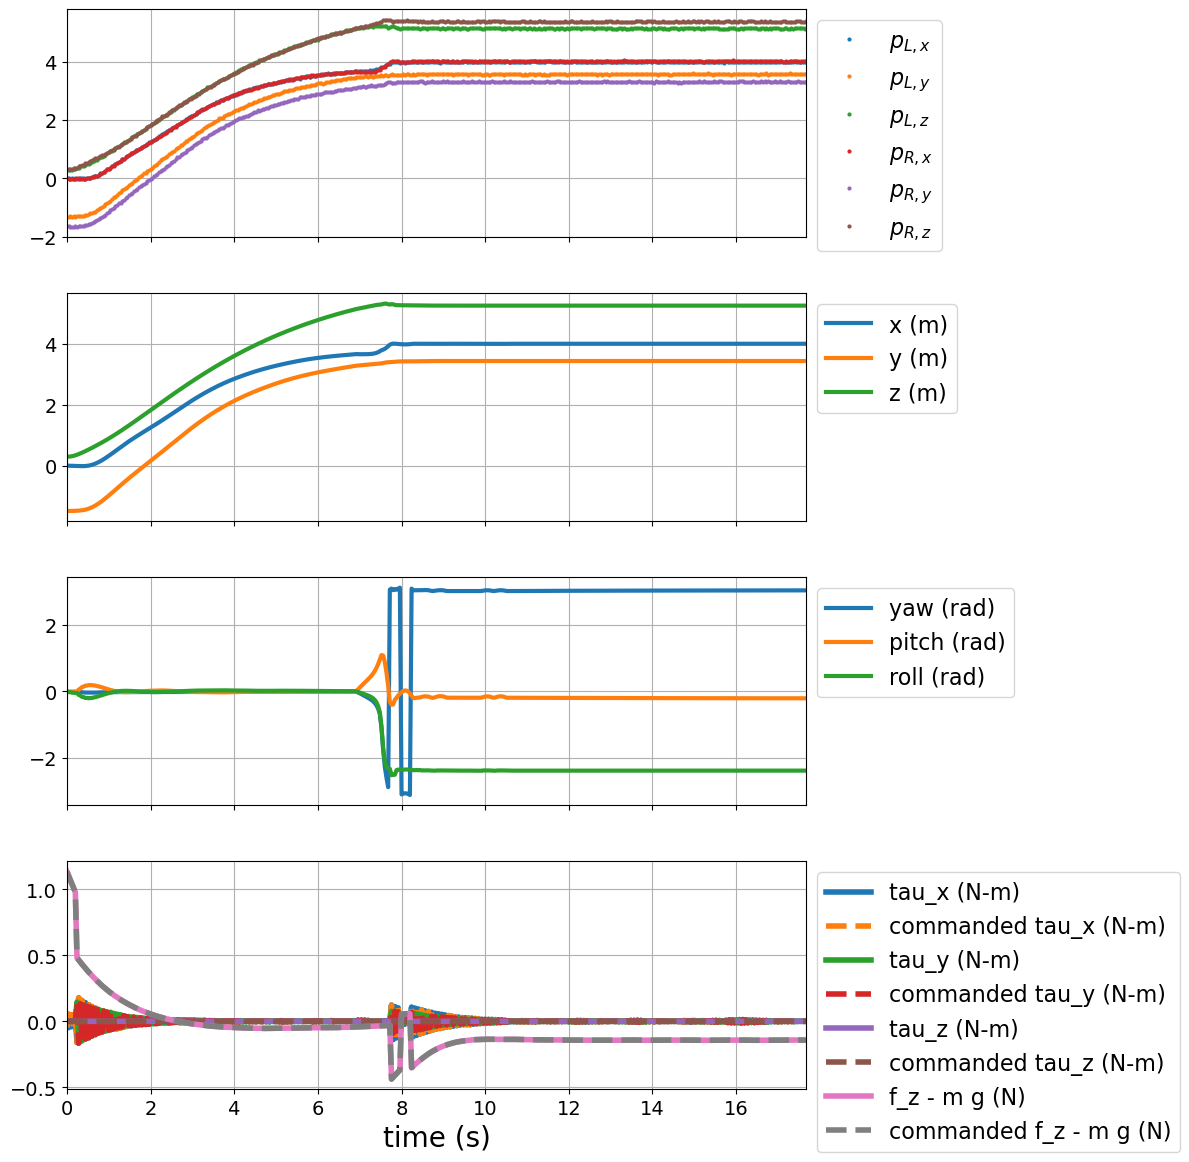

In [423]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background). Here are some best practices:

* Use the extension `.png` for rasterized, low-res images (e.g., to include in a notebook or on a website).
* Use the extension `.pdf` for vectorized, high-res images (e.g., to include in a report).

In [424]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

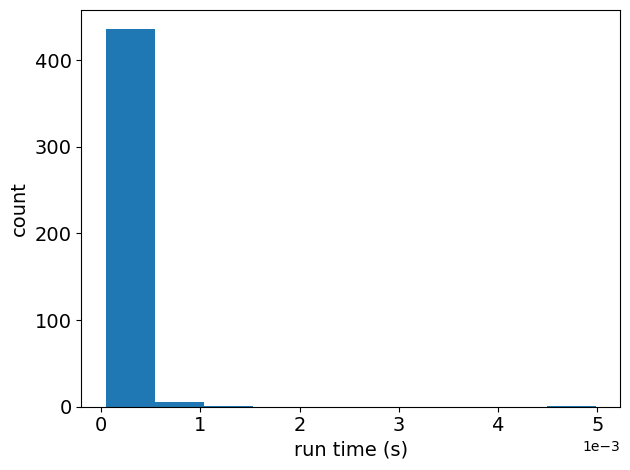

In [425]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Clear all drones.

In [426]:
simulator.clear_drones()

Load drones from `students` directory.

In [427]:
failures = simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [428]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [429]:
simulator.run(max_time=5.0)

KeyboardInterrupt: 

## Example of how to show results and keep running

Show results (so far).

In [ ]:
simulator.show_results()

FINISHED

STILL RUNNING
 template            

FAILED


Continue running simulation from same point for `max_time` seconds or until all drones either finish or are disqualified.

In [ ]:
simulator.run(max_time=10.0)

Show results (so far).

In [ ]:
simulator.show_results()

FINISHED

STILL RUNNING

FAILED
 template            


## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
failures = simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

KeyboardInterrupt: 

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.place_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to add and remove views

Add another static view in a new browser window.

In [ ]:
simulator.add_view(
    'my_top_view',  # name of view (must be unique)
    'top',          # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Add a view of a ring in a new browser window.

In [ ]:
simulator.add_ring_view(
    'my_ring_view', # name of view (must be unique)
    1,              # index of ring (between 1 and 14)
    yaw=180.,       # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    distance=2.5,   # how far away the camera is from the center of the ring
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Add a view of a drone in a new browser window.

In [ ]:
simulator.add_drone_view(
    'my_drone_view',    # name of view (must be unique)
    'template',         # name of drone
    yaw=0.,             # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    pitch=15.,          # pitch angle in degrees,
    distance=2.,        # how far away the camera is from the center of the drone
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Remove the top view. The browser window that contains this view will no longer be updated.

In [ ]:
simulator.remove_view(
    'my_top_view',      # name of view to remove
)

Removed view "my_top_view" at url "http://127.0.0.1:7003/static/"


Reset drones (places drones at random positions within the start ring). Notice that the top view isn't updated, because it no longer exists.

In [ ]:
simulator.reset()

Add another static view — from the right this time instead of from the top. This new view should appear in the same browser window that formerly contained the top view.

In [ ]:
simulator.add_view(
    'my_right_view',    # name of view (must be unique)
    'right',            # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Reset drones (places drones at random positions within the start ring). Notice that the (new) right view *is* updated,

In [ ]:
simulator.reset()

## Example of how to take a snapshot

Display a snapshot.

In [ ]:
# Set the width and height of the snapshot (must be multiples of 16)
simulator.set_snapshot_size(
    640, # <-- width
    480, # <-- height
)

# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot(
    'my_start_view',    # name of view from which to take a snapshot
)

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

Exception: there is no view with the name my_start_view

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish, saving movies from two different views. You can add or remove elements to the list of `videos` to save more or fewer movies.

In [ ]:
simulator.run(
    max_time=1.0,
    videos=[
        {
            'view_name': 'my_start_view',       # name of view from which to record a video
            'file_name': 'my_start_video.mp4',  # name of file to which video will be saved
        },
        {
            'view_name': 'my_drone_view',       # name of view from which to record a video
            'file_name': 'my_drone_video.mp4',  # name of file to which video will be saved
        }
    ],
    print_debug=True,   # this option is recommended when saving videos to track progress
)

Creating a video from view my_start_view with name my_start_video.mp4 and fps 25
Creating a video from view my_drone_view with name my_drone_video.mp4 and fps 25
 25 / 26
Simulated 26 time steps in 1.8208 seconds (14.2798 time steps per second)


## Example of how to allow print statements, long run times, and inactivity

By default, your controller will fail if any of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `1e-2` seconds for `run` (on more than 10 occasions).
* It moves less than `0.1` meters in `10.0` seconds.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)

## Example of how to find the position, orientation, and radius of each ring

This information should only be used for analysis.

In [ ]:
for i, ring in enumerate(simulator.rings):
    p = ring['p']        # <--- position of ring
    v = ring['R'][:, 0]  # <--- unit vector normal to ring (pointing through it)
    r = ring['radius']   # <--- radius of ring
    s = f'ring {i:2d}' + \
        f' : p ({p[0]:6.2f}, {p[1]:6.2f}, {p[2]:6.2f})' + \
        f' : v ({v[0]:6.2f}, {v[1]:6.2f}, {v[2]:6.2f})' + \
        f' : r ({r:6.2f})'
    print(s)

ring  0 : p (  0.00,   0.00,   0.25) : v (  0.00,   0.00,   1.00) : r (  2.50)
ring  1 : p (  4.00,   4.00,   4.00) : v (  1.00,   0.00,   0.00) : r (  1.00)
ring  2 : p (  6.10,   0.00,   4.50) : v (  0.00,  -1.00,  -0.00) : r (  1.00)
ring  3 : p (  8.20,   0.00,   4.50) : v (  0.00,   1.00,   0.00) : r (  1.00)
ring  4 : p ( 10.30,   0.00,   4.50) : v (  0.00,  -1.00,  -0.00) : r (  1.00)
ring  5 : p ( 12.40,   0.00,   4.50) : v (  0.00,   1.00,   0.00) : r (  1.00)
ring  6 : p ( 14.50,   0.00,   4.50) : v (  0.00,  -1.00,  -0.00) : r (  1.00)
ring  7 : p ( 16.60,  -4.00,   5.50) : v (  1.00,   0.00,   0.00) : r (  1.00)
ring  8 : p ( 16.60,   4.00,   2.00) : v ( -1.00,   0.00,   0.00) : r (  1.00)
ring  9 : p ( 14.50,   0.00,   4.50) : v (  0.00,  -1.00,  -0.00) : r (  1.00)
ring 10 : p ( 12.40,   0.00,   4.50) : v (  0.00,   1.00,   0.00) : r (  1.00)
ring 11 : p ( 10.30,   0.00,   4.50) : v (  0.00,  -1.00,  -0.00) : r (  1.00)
ring 12 : p (  8.20,   0.00,   4.50) : v (  0.00,   

## Example of how to specify initial conditions

Reset the simulator with given initial conditions. The argument `initial_conditions` must be a dictionary. This dictionary must have an key/value pair for each drone in the simulator. The key must be the name of the corresponding drone. The value must, itself, be a dictionary with a key/value pair for each initial state and each initial measurement.

In [ ]:
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 0.5,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 0.5,
            'yaw_meas': 0.,
        },
    },
)

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to disable and enable views

Disable views so they aren't updated while running simulations. These simulations will then run as fast as possible (much faster than real time), so this option is a good choice when collecting lots of data.

In [ ]:
simulator.disable_views()

Reset drones (places drones at random positions within the start ring). Note that views are still updated — it is only when running simulations that views aren't updated.

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish (should take much less than `max_time` seconds to run).

In [ ]:
simulator.run(max_time=5.0)

Enable views again.

In [ ]:
simulator.enable_views()

Run simulation for `max_time` seconds or until all drones finish (should take about `max_time` seconds to run).

In [ ]:
simulator.run(max_time=5.0)